## Relax Inc Take Home Challenge


The data is available as two attached CSV files: 
    - takehome_user_engagement.csv     
    - takehome_users .csv 
    
The data has the following two tables: 

1. A user table ( "takehome_users" ) with data on 12,000 users who signed up for the product in the last two years. This table includes: 
    - name: the user's name 
    
    - object_id: the user's id 
    
    - email: email address 
    
    - creation_source: how their account was created. This takes on one of 5 values: 
    
        - PERSONAL_PROJECTS: invited to join another user's personal workspace 
        
        - GUEST_INVITE: invited to an organization as a guest (limited permissions) 
        
        - ORG_INVITE: invited to an organization (as a full member) 
        
        - SIGNUP: signed up via the website 
        
        - SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id) 
        
    - creation_time: when they created their account 
    
    - last_session_creation_time: unix timestamp of last login 
    
    - opted_in_to_mailing_list: whether they have opted into receiving marketing emails 
    
    - enabled_for_marketing_drip: whether they are on the regular marketing email drip 
    
    - org_id: the organization (group of users) they belong to 
    
    - invited_by_user_id: which user invited them to join (if applicable). 
    
1. A usage summary table ( "takehome_user_engagement" ) that has a row for each day that a user logged into the product. 

**OBJECTIVE:** Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period , identify which factors predict future user adoption



In [1]:
import pandas as pd
import dateutil
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot

### Step 1: Load data

In [2]:
# read users file
df_users = pd.read_csv('data/takehome_users.csv', encoding='latin-1')

In [3]:
# change to datetime objects
df_users.creation_time = pd.to_datetime(df_users.creation_time)

In [4]:
# name and email are not going to give any value to the model, drop them now
df_users.drop(['name','email'],axis=1,inplace=True)

In [5]:
# read user_engagement file
df_usage = pd.read_csv('data/takehome_user_engagement.csv', encoding='latin-1')

In [6]:
df_usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
# change to datetime objects
df_usage.time_stamp = pd.to_datetime(df_usage.time_stamp)

### Step 2: Use usage data to calculate if user has adopted

In [8]:
# pull out date portion of timestamp
df_usage['time_date']=pd.to_datetime(df_usage['time_stamp'].dt.date)

In [9]:
# now group by user_id and time_date and at the same time eliminate duplicate dates
df_group = df_usage.groupby(['user_id','time_date']).agg({'visited':sum})

In [10]:
# reset the index on df_group
df_group = df_group.reset_index(drop=False)

In [11]:
# now calculate if login displays an adopted user (3rd time in one week)
df_group['adopted']=(df_group['user_id']==df_group['user_id'].shift(2)) \
                     &(df_group['time_date']<(df_group['time_date'].shift(2)+timedelta(days=7)))

In [12]:
# get adopted status by choosing the maximum value of adopted
df_adopted = df_group.groupby(['user_id'],as_index=False)['adopted'].max()

In [13]:
# add the adopted information to the users dataframe by merging users and adopted
df_merged = df_users.merge(df_adopted, how='left', left_on=['object_id'], right_on=['user_id'])

In [14]:
# if adopted is missing a value, set it to False
df_merged.adopted.fillna(False,inplace=True)

### Step 3: Explore Data

#### look at categorical variables

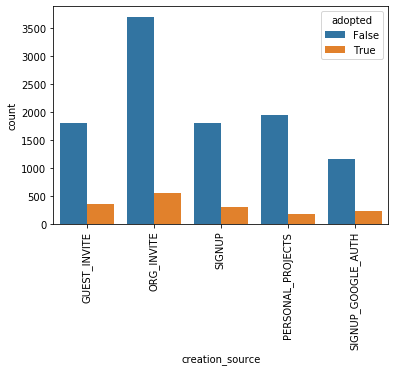

In [15]:
# Check out creation_source
_ = sns.countplot(x='creation_source', data=df_merged, hue='adopted')
_ = plt.xticks(rotation=90)

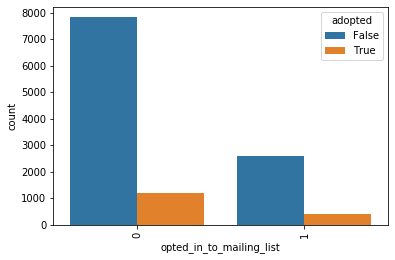

In [16]:
# Check out opted_in_to_mailing_list
_ = sns.countplot(x='opted_in_to_mailing_list', data=df_merged, hue='adopted')
_ = plt.xticks(rotation=90)

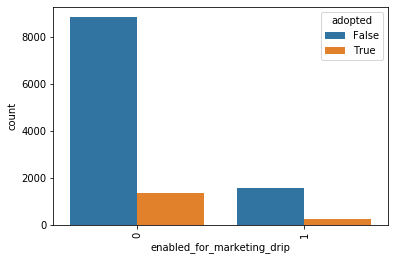

In [17]:
# Check out enabled_for_marketing_drip
_ = sns.countplot(x='enabled_for_marketing_drip', data=df_merged, hue='adopted')
_ = plt.xticks(rotation=90)

In [18]:
# check on values of numeric variables
df_merged.describe().T

,count,mean,std,min,25%,50%,75%,max
object_id,12000.0,6.000500e+03,3.464246e+03,1.000000e+00,3.000750e+03,6.000500e+03,9.000250e+03,1.200000e+04
last_session_creation_time,8823.0,1.379279e+09,1.953116e+07,1.338452e+09,1.363195e+09,1.382888e+09,1.398443e+09,1.402067e+09
opted_in_to_mailing_list,12000.0,2.495000e-01,4.327417e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
enabled_for_marketing_drip,12000.0,1.493333e-01,3.564316e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
org_id,12000.0,1.418846e+02,1.240567e+02,0.000000e+00,2.900000e+01,1.080000e+02,2.382500e+02,4.160000e+02
invited_by_user_id,6417.0,5.962957e+03,3.383762e+03,3.000000e+00,3.058000e+03,5.954000e+03,8.817000e+03,1.199900e+04
user_id,8823.0,6.019822e+03,3.464251e+03,1.000000e+00,3.017500e+03,6.034000e+03,9.029500e+03,1.200000e+04


In [19]:
# create a new feature, that will convert creation_time to how many days the user has been on the system
#    use the latest date from the usage data as the extract date
extract_dt = pd.to_datetime(max(df_usage['time_date']))
df_merged['age'] = (extract_dt-df_merged['creation_time']).dt.days

In [20]:
# the last session creation time is available from two sources last_session_creation_time on users and
#    the maximum date from the usage table. Combine this information into a binary variable, =0 if they never
#    logged in or 1 if they have had a login
df_merged['active'] =  df_merged['last_session_creation_time'].isnull().astype(int)

### invited_by_user_id
the invited_by_user_id is a categorical variable and can provide two types of information:

    1) whether a user recevied an invitation - transform to an 0/1 indicator
    
    2) how many times they have invited someone to join - create count of invitations

In [21]:
# create invited flag
df_merged['invited'] =  df_merged['invited_by_user_id'].isnull().astype(int)

In [22]:
# get number of invitations by each user_id
df_inv = df_merged.groupby('invited_by_user_id',as_index=False)['adopted'].agg({'invites': 'count'})

In [23]:
# merge df_inv with previous merge
df_merged2 = df_merged.merge(df_inv, how='left', left_on=['object_id'], right_on=['invited_by_user_id'])

In [24]:
# set missing values of invites to 0
df_merged2.invites.fillna(0,inplace=True)

In [25]:
# drop the columns that are no longer of interest
df_merged2.drop(['creation_time','last_session_creation_time','invited_by_user_id_x','user_id','invited_by_user_id_y'],axis=1,inplace=True)

In [26]:
# create dummy variables for creation_source
df_with_dummies = pd.get_dummies(df_merged2, prefix='creation_source', columns=['creation_source'])

### Step 3: Explore the data

In [27]:
# get unique counts for each column in df_with_dummies
for col in df_with_dummies.columns: print(col, df_with_dummies[col].nunique())

object_id 12000
opted_in_to_mailing_list 2
enabled_for_marketing_drip 2
org_id 417
adopted 2
age 730
active 2
invited 2
invites 14
creation_source_GUEST_INVITE 2
creation_source_ORG_INVITE 2
creation_source_PERSONAL_PROJECTS 2
creation_source_SIGNUP 2
creation_source_SIGNUP_GOOGLE_AUTH 2


In [28]:
# instead of having adopted as a boolean, change it to an integer
df_with_dummies['adopted']=df_with_dummies['adopted'].astype(int)

In [29]:
# index on object_id
df_with_dummies = df_with_dummies.set_index(['object_id'])

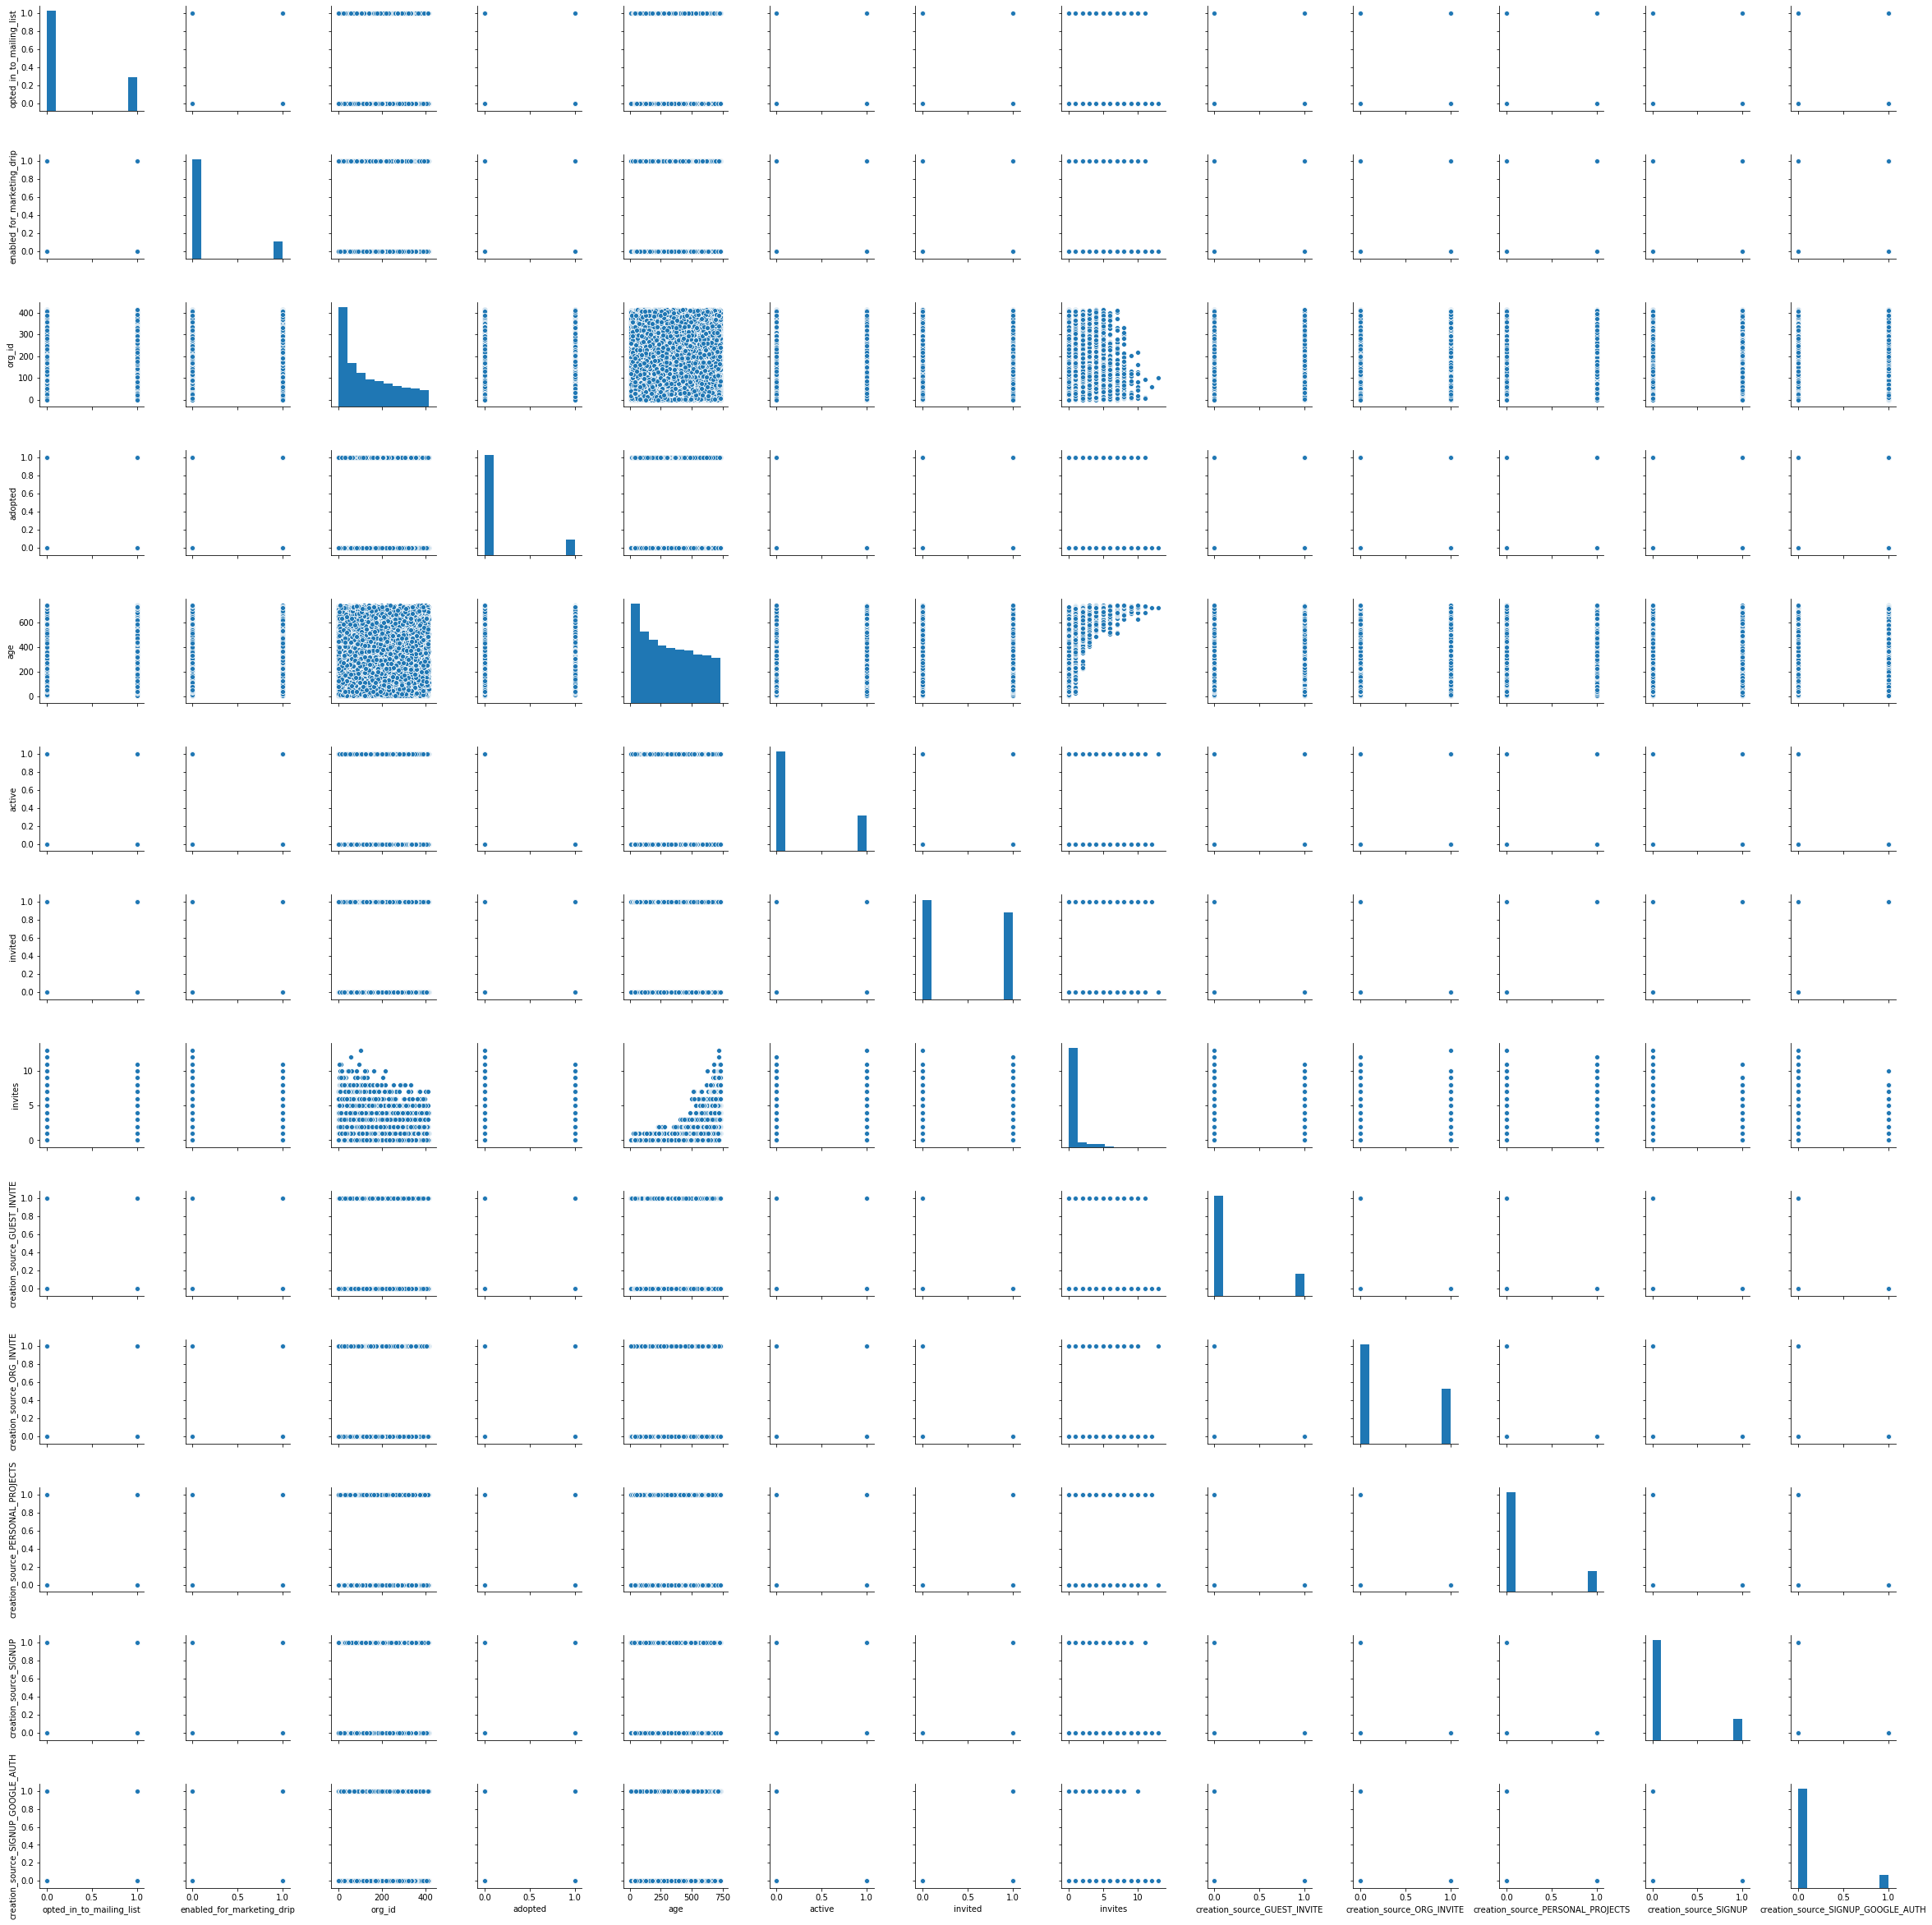

In [30]:
# display the pairplots
sns.pairplot(df_with_dummies)

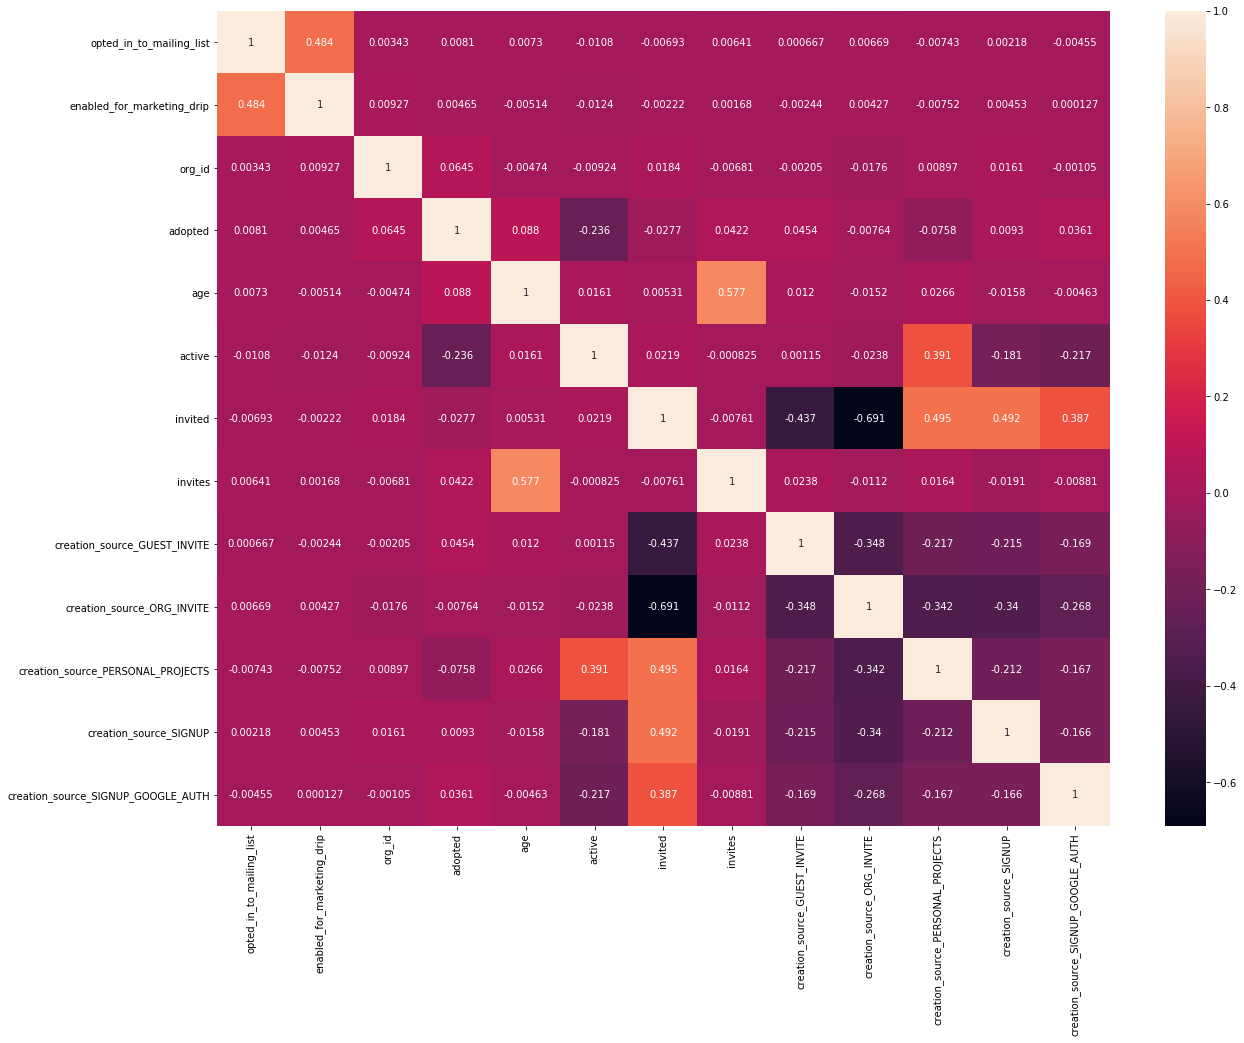

In [31]:
# display a correlation heatmap
corr = df_with_dummies.corr()

plt.subplots(figsize=(20,15))
# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, fmt='.3g')

### Step 4: Modeling
This is a classification problem: to identify which factors predict adoption (a binary classifier, yes or no). 

The fields which are now in df_with_dummies are:

|field                               |description|
|:---    |:--- |
|'object_id'                         | index - user's id|
|'opted_in_to_mailing_list'          | 0/1 flag for receiving marketing emails|
|'enabled_for_marketing_drip'        | 0/1 flag for being on regular marketing email drip|       
    |'org_id'                            | categorical variable - group of users to which they belong|
    |'adopted'                           | 0/1 flag for whether they are considered an adopted user|
    |'age'                               | number of days since creation|
    |'active'                            | 0/1 flag for if they have ever logged in|
    |'invited'                           | 0/1 flag for if they were invited to join|
    |'invites'                           | number of invites they have made|
    |'creation_source_GUEST_INVITE'      |
    |'creation_source_ORG_INVITE'        |
    |'creation_source_PERSONAL_PROJECTS' |
    |'creation_source_SIGNUP'            |
    |'creation_source_SIGNUP_GOOGLE_AUTH'|

In [32]:
# set up features and target variables 
y = df_with_dummies['adopted']
X = df_with_dummies.drop(['adopted','org_id'],axis=1)

In [33]:
# scale X
mm_scaler = preprocessing.MinMaxScaler()
X_scaled = mm_scaler.fit_transform(X)

In [34]:
# divide into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=57)

#### model01 - logistic regression

In [35]:
model01 = LogisticRegression()
model01.fit(X_train, y_train)
y_pred01 = model01.predict(X_test)

In [36]:
# show model results
labels = [False, True]
cm01 = confusion_matrix(y_test, y_pred01, labels)
print(cm01)
print(classification_report(y_test,y_pred01))

print('Accuracy of the Logistic Regression Classifier on test set: {:.3f}'.format(model01.score(X_test, y_test)))

[[3135    0]
 [ 465    0]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      3135
           1       0.00      0.00      0.00       465

    accuracy                           0.87      3600
   macro avg       0.44      0.50      0.47      3600
weighted avg       0.76      0.87      0.81      3600

Accuracy of the Logistic Regression Classifier on test set: 0.871


C:\Users\Nancy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### model02 - LinearSVC

In [37]:
model02 = LinearSVC()
model02.fit(X_train, y_train)
y_pred02 = model02.predict(X_test)

In [38]:
# show model results
labels = [False, True]
cm02 = confusion_matrix(y_test, y_pred02, labels)
print(cm02)
print(classification_report(y_test,y_pred02))


print('Accuracy of the LinearSVC on test set: {:.3f}'.format(model02.score(X_test, y_test)))

[[3135    0]
 [ 465    0]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      3135
           1       0.00      0.00      0.00       465

    accuracy                           0.87      3600
   macro avg       0.44      0.50      0.47      3600
weighted avg       0.76      0.87      0.81      3600

Accuracy of the LinearSVC on test set: 0.871


C:\Users\Nancy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### model03 - Random Forest

In [39]:
model03 = RandomForestClassifier(class_weight='balanced', n_estimators=100)
model03.fit(X_train, y_train)
y_pred03 = model03.predict(X_test)

[[2667  468]
 [ 361  104]]
              precision    recall  f1-score   support

           0       0.88      0.85      0.87      3135
           1       0.18      0.22      0.20       465

    accuracy                           0.77      3600
   macro avg       0.53      0.54      0.53      3600
weighted avg       0.79      0.77      0.78      3600

Accuracy of the Random Forest on test set: 0.770


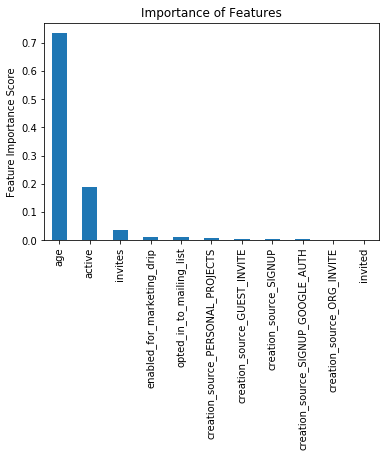

In [40]:
# show model results
labels = [False, True]
cm03 = confusion_matrix(y_test, y_pred03, labels)
print(cm03)
print(classification_report(y_test,y_pred03))

predictors=list(X.columns)
feat_imp03 = pd.Series(model03.feature_importances_, predictors).sort_values(ascending=False)
feat_imp03.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the Random Forest on test set: {:.3f}'.format(model03.score(X_test, y_test)))

### Step 5: Tune Model Parameters

The first two models returned no predictions of adoptions, likely due to the imbalance in the classes. The Random Forest model gave a more balanced response, I will try to tune it further.

In [41]:
# First create the base model to tune
rf2 = RandomForestClassifier(class_weight='balanced')

# Set up grid search of hyperparameters
random_grid = {"max_features": ['auto', 'sqrt'],
               "max_depth": [1,10,20,30,40,50,60,70,80,90,100, None],
               "min_samples_leaf": [1,3,10],
               "min_samples_split": [2,5,10],
               "bootstrap": [True, False],
               "n_estimators": [10,100]}
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf2, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=10, random_state=42, n_jobs = -1)

In [42]:
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   49.1s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
         

In [43]:
# display best parameters
rf_random.best_params_

{'n_estimators': 10,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

### Step 6: Rerun with best parameters

In [44]:
# rerun model with best parameters
rf3 = RandomForestClassifier(class_weight='balanced',
                                 n_estimators = 10,
                                 min_samples_split=2,
                                 min_samples_leaf=1,
                                 max_features='sqrt',
                                 max_depth= 50,
                                 bootstrap = True)
    
model04 = rf3.fit(X_train,y_train)

In [45]:
# run test against new model
y_pred04 =model04.predict(X_test)

[[2722  413]
 [ 373   92]]
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      3135
           1       0.18      0.20      0.19       465

    accuracy                           0.78      3600
   macro avg       0.53      0.53      0.53      3600
weighted avg       0.79      0.78      0.79      3600

Accuracy of the Random Forest Model on test set: 0.782


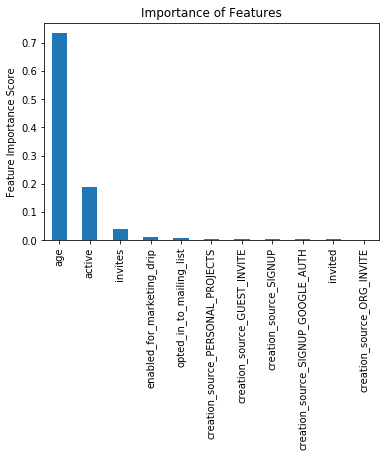

In [47]:
# show model results
cm04 = confusion_matrix(y_test, y_pred04, labels)
print(cm04)
print(classification_report(y_test,y_pred04))

predictors=list(X.columns)
feat_imp = pd.Series(model04.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the Random Forest Model on test set: {:.3f}'.format(model04.score(X_test, y_test)))

## Conclusion
This was a very imbalanced dataset, there were far more users who never became active. 

The three factors that held the most weight in predicting that a user would "adopt" the service are:
1. Age - the longer it has been since the initial signup, the more likely it is that the user will adopt.
1. Active - whether or not a user had actually ever logged into the service
1. Invites - users who invited others were more likely to have adopted for themselves.